In [2]:
!pip install gymnasium
!pip install matplotlib
!pip install gym
!pip install pygame

In [3]:
import gymnasium as gym
import matplotlib.pyplot as plt


# launch adventure environment with human rendering
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False,  render_mode="rgb_array")
env.reset()

number_of_actions = env.action_space.n

In [4]:

from llama_cpp import Llama
import numpy as np
import re


class LLM_Agent:

    def __init__(self):
        self.llm = Llama(model_path="../model/wizardLM-7B.ggmlv3.q4_1.bin", logits_all=True)

        # RL specific variables
        self.observations = []
        self.rewards = []


        self.memory = [] # extract previous epsiodes from game
        self.belief = [] # extract rules from game

    def set_action_space(self, action_space):
        self.action_space = action_space
        self.text_action_space = ', '.join(f"'{w}'" for w in action_space)
        print("action space: ", self.action_space)

    def get_action_prompt(self):
        prompt = (
            f"{self.character_prompt}"
            f"You can move in the following directions: {self.text_action_space}. "
            f"This is your last observation about positioning in the game {self.observations[-1]}. "
            # f"Please output one of the possible actions. "
            f"What direction should the player move? (please provide only the direction name, one word) "
            f"If you are unsure, please output one of the directions listed before as you are learning how to play. "
            # f"Choose an action to take: "
        )
        return prompt

    def set_character_prompt(self, character_prompt):
        self.character_prompt = character_prompt

    def generate(self, prompt):
        return self.llm(f"""{prompt}""", echo=True)
    
    def save_observation(self, observation):
        self.observations.append(observation)
        print(f"saved observation: {observation}")

    def save_reward(self, reward):
        self.rewards.append(reward)
    
    def generate_action(self, debug=False):
        print("generate_action")

        prompt = self.get_action_prompt()
        print(f"get_action_prompt: {prompt}")

        # TODO check actions are valid
        output = self.generate(prompt)
        print(f"generated output: {output}")
        
        generated_text = output['choices'][0]['text']
        print(f"generated text: {generated_text}")
        print("----------------------------------------------")
        
        # Find the direction chosen by the LLM_agent
        # generated_direction = re.search("'([^']+)'", generated_text)
        # print(f"Generated direction: {generated_direction.group(1)}")


        # TODO beam search would be better here or using raw logits
        

        # for all actions in action space check at which index it appears in the generated text
        # the action with the lowest index is the action we want to take
        text_index = 1000
        action_number = -1
        # times_found = -1
        print("---------------------------------------------------------------------------------------------------")
        print("Searching for action in generated text")
        for i, current_action in enumerate(self.action_space):
            # TODO - THSI is not working - make it look properly into the generated text
            action_index = generated_text.find(current_action, generated_text.find(" directions listed before as you are learning how to play.") + 1)
            print(f"action: {current_action}, index: {action_index}")
            if action_index != -1 and action_index < text_index:
                # times_found += 1
                # print(f"looking for action {current_action} in generated text ")
                # print(f"action found {times_found} times")
                print(f"action {current_action} found at index {action_index}")
                text_index = action_index
                action_number = i
                break


            # we want to skip the first occurence of the action
            # since the first time it is in the text is when we are giving instructions to the LLM
            # if times_found >= 1:
            #     text_index = action_index
            #     action_number = i
               
                

        if action_number == -1:
            # raise Exception("No action found in generated text")
            # print warning in red
            print("\033[91mNo action found in generated text\033[0m")
            # randomly select action
            action_number = np.random.randint(0, len(self.action_space))
        
        return action_number
    


In [5]:
# Some random notes / ideas

# multiple model controller, critic
# queue and planning
# long term memory 
# react 
# https://github.com/luca-medeiros/lang-segment-anything
# autonomous agents text us back if does know what to do and learn from it

In [6]:
# Your a video game player, your goal is to get the key and get out of the dungeon

agent = LLM_Agent()

# TODO check if this actually does anything
# env.action_space

action_space = [ 'left', 'down', 'right', 'up']
# action_space = env.action_space.seed(0)
# action_space = []

# for i in range(env.action_space.n):
#     print(i)
#     action_space.append(env.action_space.seed(i)[0])
#     print(action_space)


# print("action space: ", action_space)

# how can we get the agent to learn the action space
agent.set_action_space(action_space=action_space)

agent.set_character_prompt("We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. ")

action space:  ['left', 'down', 'right', 'up']


llama.cpp: loading model from ../model/wizardLM-7B.ggmlv3.q4_1.bin
llama_model_load_internal: format     = ggjt v3 (latest)
llama_model_load_internal: n_vocab    = 32001
llama_model_load_internal: n_ctx      = 512
llama_model_load_internal: n_embd     = 4096
llama_model_load_internal: n_mult     = 256
llama_model_load_internal: n_head     = 32
llama_model_load_internal: n_layer    = 32
llama_model_load_internal: n_rot      = 128
llama_model_load_internal: ftype      = 3 (mostly Q4_1)
llama_model_load_internal: n_ff       = 11008
llama_model_load_internal: n_parts    = 1
llama_model_load_internal: model size = 7B
llama_model_load_internal: ggml ctx size =    0.07 MB
llama_model_load_internal: mem required  = 5809.34 MB (+ 1026.00 MB per state)
.
llama_init_from_file: kv self size  =  256.00 MB
AVX = 0 | AVX2 = 0 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 0 | NEON = 1 | ARM_FMA = 1 | F16C = 0 | FP16_VA = 1 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 0 | VSX = 0 | 


observation: (0, {'prob': 1})
episode_reward: 0
=> TIMESTAMP [0]; EPISODE [0]<=
position: 0
saved observation: you are in position 0. This is the start of the game.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 0. This is the start of the game.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-f4df55bb-9c08-4b7e-8308-8f67ce77d23c', 'object': 'text_completion', 'created': 1686082339, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 0. This is the start of the game.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe player should move 'down'.", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 148, 'completion_tokens': 8, 'total_tokens': 156}}
generated text: We are testing if


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     6.43 ms /     9 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3605.55 ms /    50 tokens (   72.11 ms per token)
llama_print_timings:        eval time =   405.53 ms /     8 runs   (   50.69 ms per token)
llama_print_timings:       total time =  4119.76 ms


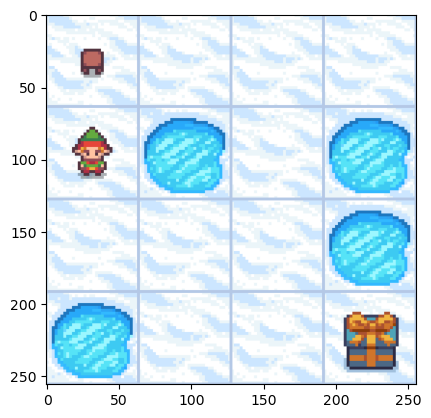

--------------------
obs: 4
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [1]; EPISODE [0]<=
position: 4
saved observation: you are in position 4. You moved from position 0. Your last action was to go down.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 4. You moved from position 0. Your last action was to go down.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-a1f7b400-37b1-4985-8f77-0a420cc61051', 'object': 'text_completion', 'created': 1686082343, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 4. You moved from position 0. Your last action was to go down.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nI'm sorry, but I am not capable of determining the correct direction for the player to move based on the given information. The player's last action was to go down, but the


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =    54.81 ms /    77 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3511.42 ms /    59 tokens (   59.52 ms per token)
llama_print_timings:        eval time =  3956.98 ms /    76 runs   (   52.07 ms per token)
llama_print_timings:       total time =  8012.56 ms


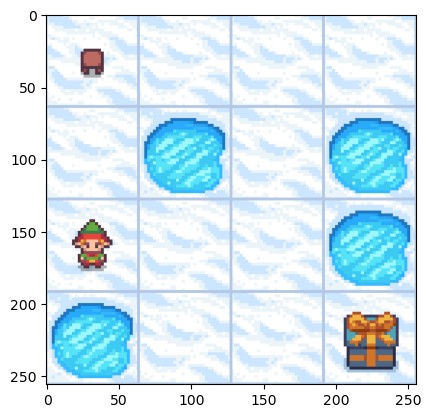

--------------------
obs: 8
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [2]; EPISODE [0]<=
position: 8
saved observation: you are in position 8. You moved from position 4. Your last action was to go down.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 8. You moved from position 4. Your last action was to go down.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-7d215ec9-72e8-4a48-b3b0-d00fd630be05', 'object': 'text_completion', 'created': 1686082351, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 8. You moved from position 4. Your last action was to go down.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe player should move right.", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 155, 'completion_tokens': 7, 'total_tokens': 162}}
gener


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     5.66 ms /     8 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3505.23 ms /    59 tokens (   59.41 ms per token)
llama_print_timings:        eval time =   359.67 ms /     7 runs   (   51.38 ms per token)
llama_print_timings:       total time =  3980.95 ms


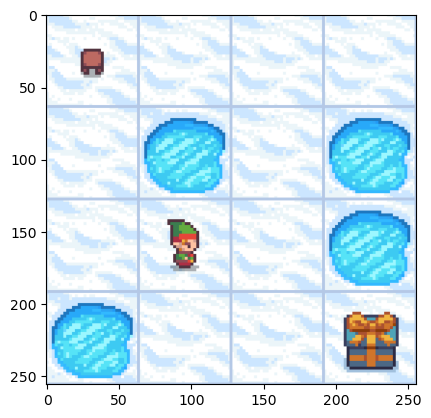

--------------------
obs: 9
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [3]; EPISODE [0]<=
position: 9
saved observation: you are in position 9. You moved from position 8. Your last action was to go right.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 9. You moved from position 8. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-508e75d2-f625-4510-9414-ec969753c38b', 'object': 'text_completion', 'created': 1686082355, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 9. You moved from position 8. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe player should move 'right'.", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 155, 'completion_tokens': 8, 'total_tokens': 163}}
ge


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     6.38 ms /     9 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3479.20 ms /    59 tokens (   58.97 ms per token)
llama_print_timings:        eval time =   397.62 ms /     8 runs   (   49.70 ms per token)
llama_print_timings:       total time =  3980.07 ms


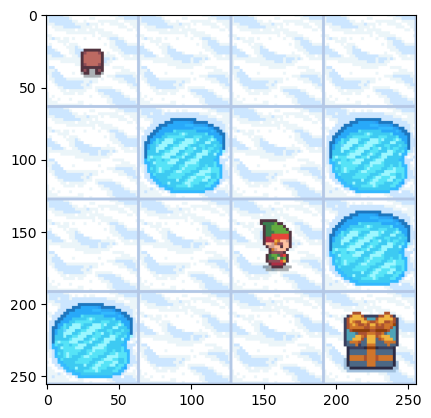

--------------------
obs: 10
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [4]; EPISODE [0]<=
position: 10
saved observation: you are in position 10. You moved from position 9. Your last action was to go right.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 10. You moved from position 9. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-61cab949-20dd-42cb-85ac-938d951e3446', 'object': 'text_completion', 'created': 1686082360, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 10. You moved from position 9. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe player should move to the down direction.", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 156, 'completion_tokens': 10, 'total_t


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     7.84 ms /    11 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3509.25 ms /    60 tokens (   58.49 ms per token)
llama_print_timings:        eval time =   496.84 ms /    10 runs   (   49.68 ms per token)
llama_print_timings:       total time =  4117.97 ms


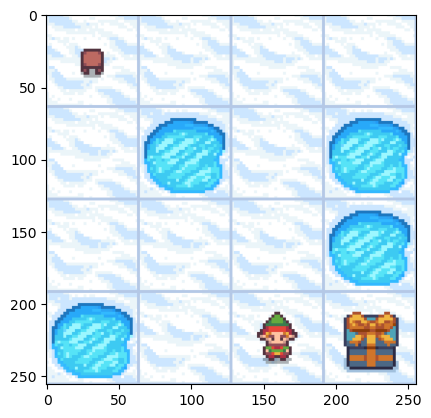

--------------------
obs: 14
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [5]; EPISODE [0]<=
position: 14
saved observation: you are in position 14. You moved from position 10. Your last action was to go down.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 14. You moved from position 10. Your last action was to go down.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-63f4270e-0149-4c3d-957c-c353d3765fe1', 'object': 'text_completion', 'created': 1686082364, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 14. You moved from position 10. Your last action was to go down.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \n\nAs an AI assistant, I do not have access to your current position or any knowledge about the game you are playing. Therefore, I cannot provide a specific direction for 


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =    62.93 ms /    88 runs   (    0.72 ms per token)
llama_print_timings: prompt eval time =  3500.41 ms /    60 tokens (   58.34 ms per token)
llama_print_timings:        eval time =  4577.90 ms /    87 runs   (   52.62 ms per token)
llama_print_timings:       total time =  8625.19 ms


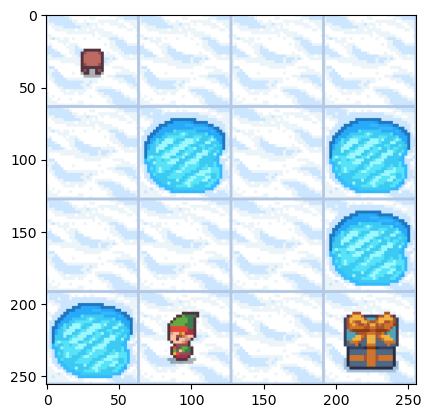

--------------------
obs: 13
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [6]; EPISODE [0]<=
position: 13
saved observation: you are in position 13. You moved from position 14. Your last action was to go left.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 13. You moved from position 14. Your last action was to go left.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-a1028ff1-e388-4428-b41f-606f88c87595', 'object': 'text_completion', 'created': 1686082372, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 13. You moved from position 14. Your last action was to go left.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe player should move right.", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 157, 'completion_tokens': 7, 'total_tokens': 164}}
gen


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     5.76 ms /     8 runs   (    0.72 ms per token)
llama_print_timings: prompt eval time =  3619.19 ms /    60 tokens (   60.32 ms per token)
llama_print_timings:        eval time =   355.28 ms /     7 runs   (   50.75 ms per token)
llama_print_timings:       total time =  4093.64 ms


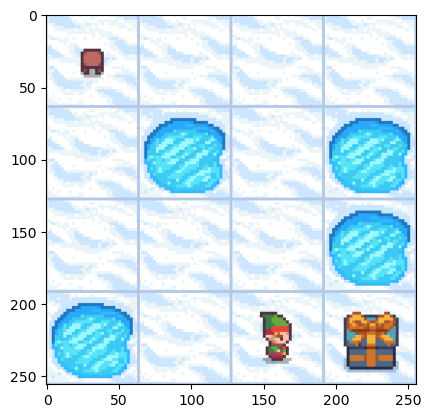

Llama.generate: prefix-match hit


--------------------
obs: 14
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [7]; EPISODE [0]<=
position: 14
saved observation: you are in position 14. You moved from position 13. Your last action was to go right.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 14. You moved from position 13. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 
generated output: {'id': 'cmpl-0440a64c-daa8-443a-836e-fde949


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =    64.56 ms /    90 runs   (    0.72 ms per token)
llama_print_timings: prompt eval time =  3541.34 ms /    60 tokens (   59.02 ms per token)
llama_print_timings:        eval time =  5068.63 ms /    89 runs   (   56.95 ms per token)
llama_print_timings:       total time =  9165.22 ms


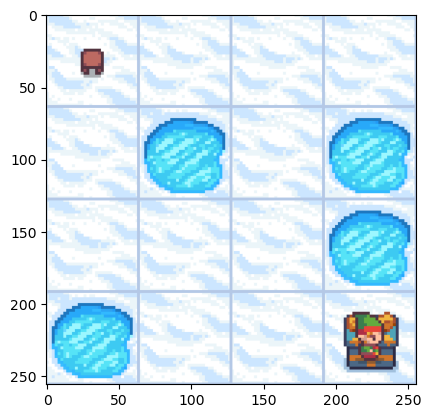

Llama.generate: prefix-match hit


--------------------
obs: 15
reward: 1.0
terminated: True
truncated: False
info: {'prob': 1.0}
--------------------
Episode finished after 8 timesteps
observation: (0, {'prob': 1})
episode_reward: 0
=> TIMESTAMP [0]; EPISODE [1]<=
position: 0
saved observation: you are in position 0. You moved from position 14. Your last action was to go right.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 0. You moved from position 14. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learn


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     7.31 ms /    10 runs   (    0.73 ms per token)
llama_print_timings: prompt eval time =  3523.78 ms /    60 tokens (   58.73 ms per token)
llama_print_timings:        eval time =   484.53 ms /     9 runs   (   53.84 ms per token)
llama_print_timings:       total time =  4133.99 ms


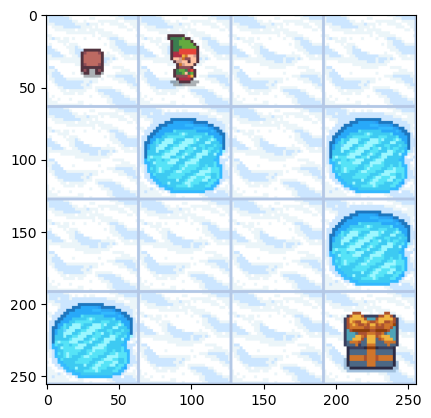

--------------------
obs: 1
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [1]; EPISODE [1]<=
position: 1
saved observation: you are in position 1. You moved from position 0. Your last action was to go right.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 1. You moved from position 0. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-6bc6a010-feb3-4c1c-aa34-01991c259141', 'object': 'text_completion', 'created': 1686082390, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 1. You moved from position 0. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe player can move in the following directions: 'left', 'down', 'right', 'up'. Therefore, the player should move to the right.", 'index': 0, 'logprobs': None, 'finish_rea


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =    23.61 ms /    33 runs   (    0.72 ms per token)
llama_print_timings: prompt eval time =  3535.11 ms /    59 tokens (   59.92 ms per token)
llama_print_timings:        eval time =  1668.75 ms /    32 runs   (   52.15 ms per token)
llama_print_timings:       total time =  5410.66 ms


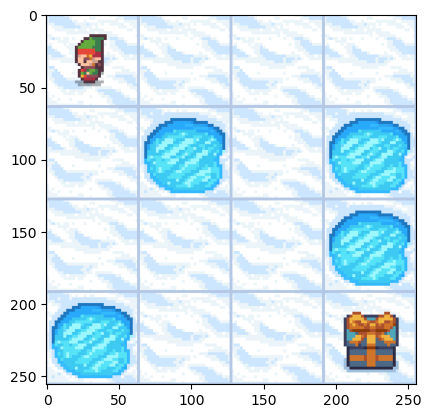

--------------------
obs: 0
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [2]; EPISODE [1]<=
position: 0
saved observation: you are in position 0. You moved from position 1. Your last action was to go left.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 0. You moved from position 1. Your last action was to go left.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-f5f20bf2-b642-4e00-97a4-bd6cfd382d82', 'object': 'text_completion', 'created': 1686082396, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 0. You moved from position 1. Your last action was to go left.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe player can move in the following directions: 'left', 'down', 'right', 'up'. Based on your observation, it seems that the player is facing north. Therefore, the player s


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =    34.27 ms /    48 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3523.72 ms /    59 tokens (   59.72 ms per token)
llama_print_timings:        eval time =  2611.95 ms /    47 runs   (   55.57 ms per token)
llama_print_timings:       total time =  6435.32 ms


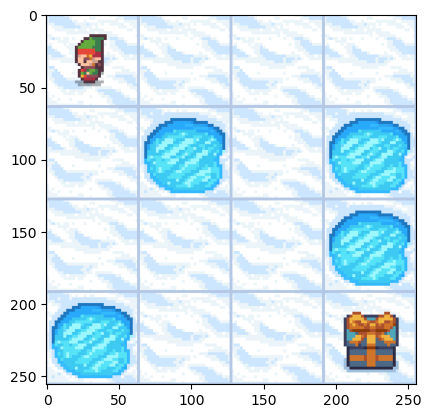

--------------------
obs: 0
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [3]; EPISODE [1]<=
position: 0
saved observation: you are still in position 0. You did not move. Your last action was to go left.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are still in position 0. You did not move. Your last action was to go left.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-75a08c0a-ad3b-4211-87ca-c71ed3dc8fb7', 'object': 'text_completion', 'created': 1686082402, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are still in position 0. You did not move. Your last action was to go left.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe player should move to the right.", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 154, 'completion_tokens': 9, 'total_tokens': 163}}
g


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     7.20 ms /    10 runs   (    0.72 ms per token)
llama_print_timings: prompt eval time =  3373.32 ms /    61 tokens (   55.30 ms per token)
llama_print_timings:        eval time =   503.72 ms /     9 runs   (   55.97 ms per token)
llama_print_timings:       total time =  4000.49 ms


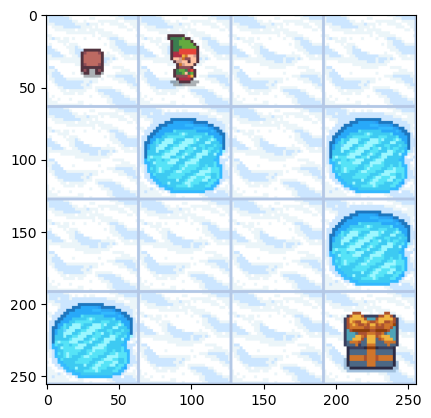

Llama.generate: prefix-match hit


--------------------
obs: 1
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [4]; EPISODE [1]<=
position: 1
saved observation: you are in position 1. You moved from position 0. Your last action was to go right.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 1. You moved from position 0. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 
generated output: {'id': 'cmpl-b8b75249-c9ca-410c-9940-bd7a040c9165


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     7.95 ms /    11 runs   (    0.72 ms per token)
llama_print_timings: prompt eval time =  3515.17 ms /    62 tokens (   56.70 ms per token)
llama_print_timings:        eval time =   911.70 ms /    10 runs   (   91.17 ms per token)
llama_print_timings:       total time =  4578.07 ms


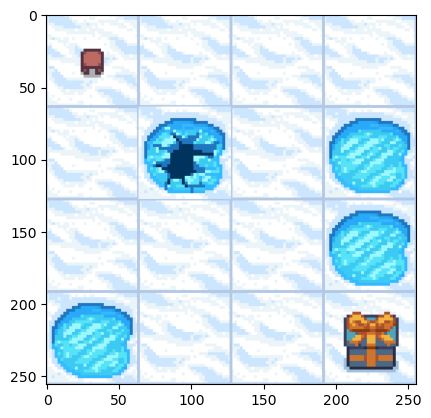

--------------------
obs: 5
reward: 0.0
terminated: True
truncated: False
info: {'prob': 1.0}
--------------------
Episode finished after 5 timesteps
observation: (0, {'prob': 1})
episode_reward: 0
=> TIMESTAMP [0]; EPISODE [2]<=
position: 0
saved observation: you are in position 0. You moved from position 1. Your last action was to go down.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 0. You moved from position 1. Your last action was to go down.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning h

Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-482dabcb-4aa2-40eb-a395-9256a992c7bc', 'object': 'text_completion', 'created': 1686082411, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 0. You moved from position 1. Your last action was to go down.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe correct answer is 'down'.", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 155, 'completion_tokens': 8, 'total_tokens': 163}}
gener


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     6.41 ms /     9 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3842.08 ms /    59 tokens (   65.12 ms per token)
llama_print_timings:        eval time =   457.21 ms /     8 runs   (   57.15 ms per token)
llama_print_timings:       total time =  4433.82 ms


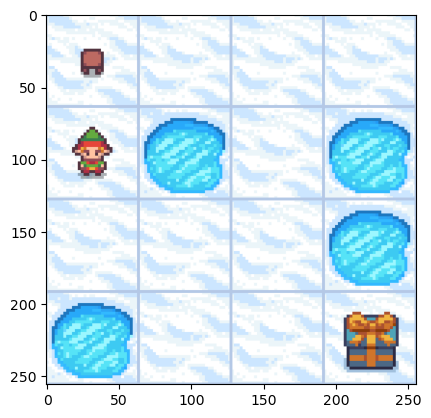

--------------------
obs: 4
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [1]; EPISODE [2]<=
position: 4
saved observation: you are in position 4. You moved from position 0. Your last action was to go down.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 4. You moved from position 0. Your last action was to go down.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-a2dc5cac-a02e-4bc6-9dbc-f440b733daea', 'object': 'text_completion', 'created': 1686082415, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 4. You moved from position 0. Your last action was to go down.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe player can move in the following directions: 'left', 'down', 'right', 'up'. Based on your observation and last action, it is unclear which direction the player should m


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =    47.32 ms /    66 runs   (    0.72 ms per token)
llama_print_timings: prompt eval time =  3550.85 ms /    59 tokens (   60.18 ms per token)
llama_print_timings:        eval time =  3537.12 ms /    65 runs   (   54.42 ms per token)
llama_print_timings:       total time =  7477.04 ms


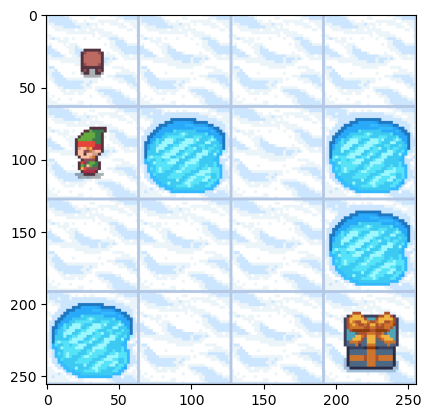

Llama.generate: prefix-match hit


--------------------
obs: 4
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [2]; EPISODE [2]<=
position: 4
saved observation: you are still in position 4. You did not move. Your last action was to go left.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are still in position 4. You did not move. Your last action was to go left.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 
generated output: {'id': 'cmpl-fe3fb8b5-9a11-46ce-ad55-608a1ad2f854', 'obje


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     6.49 ms /     9 runs   (    0.72 ms per token)
llama_print_timings: prompt eval time =  3457.15 ms /    61 tokens (   56.67 ms per token)
llama_print_timings:        eval time =   459.32 ms /     8 runs   (   57.42 ms per token)
llama_print_timings:       total time =  4058.69 ms


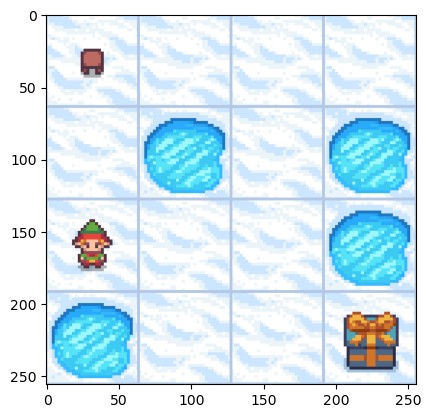

--------------------
obs: 8
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [3]; EPISODE [2]<=
position: 8
saved observation: you are in position 8. You moved from position 4. Your last action was to go down.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 8. You moved from position 4. Your last action was to go down.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-4656ce45-f135-4b55-b771-0e066e807560', 'object': 'text_completion', 'created': 1686082427, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 8. You moved from position 4. Your last action was to go down.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe player should move right.", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 155, 'completion_tokens': 7, 'total_tokens': 162}}
gener


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     5.77 ms /     8 runs   (    0.72 ms per token)
llama_print_timings: prompt eval time =  3360.30 ms /    62 tokens (   54.20 ms per token)
llama_print_timings:        eval time =   390.72 ms /     7 runs   (   55.82 ms per token)
llama_print_timings:       total time =  3856.07 ms


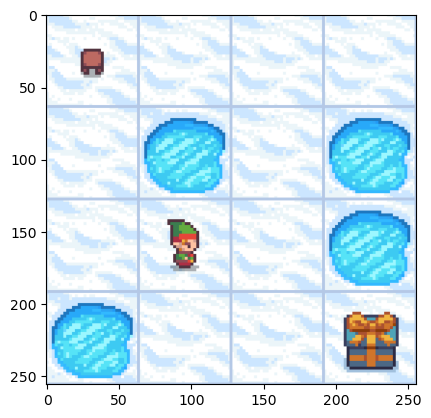

--------------------
obs: 9
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [4]; EPISODE [2]<=
position: 9
saved observation: you are in position 9. You moved from position 8. Your last action was to go right.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 9. You moved from position 8. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-7be676c1-c0c1-4763-b4a6-d63512aa9ee5', 'object': 'text_completion', 'created': 1686082431, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': 'We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: \'left\', \'down\', \'right\', \'up\'. This is your last observation about positioning in the game you are in position 9. You moved from position 8. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe AI language model does not have access to the specific game being tested and cannot predict the outcome of a particular action in that game without further inf


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =    62.33 ms /    87 runs   (    0.72 ms per token)
llama_print_timings: prompt eval time =  3497.88 ms /    59 tokens (   59.29 ms per token)
llama_print_timings:        eval time =  4424.61 ms /    86 runs   (   51.45 ms per token)
llama_print_timings:       total time =  8426.47 ms


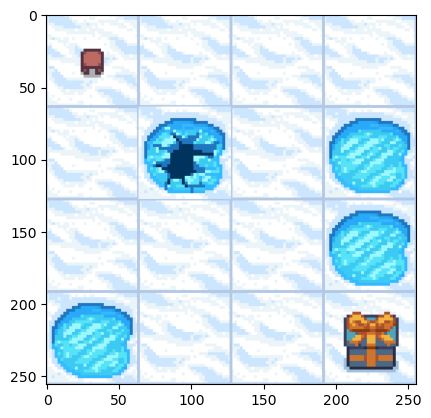

Llama.generate: prefix-match hit


--------------------
obs: 5
reward: 0.0
terminated: True
truncated: False
info: {'prob': 1.0}
--------------------
Episode finished after 5 timesteps
observation: (0, {'prob': 1})
episode_reward: 0
=> TIMESTAMP [0]; EPISODE [3]<=
position: 0
saved observation: you are in position 0. You moved from position 9. Your last action was to go up.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 0. You moved from position 9. Your last action was to go up.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how t


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     6.43 ms /     9 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3683.91 ms /    59 tokens (   62.44 ms per token)
llama_print_timings:        eval time =   404.48 ms /     8 runs   (   50.56 ms per token)
llama_print_timings:       total time =  4211.85 ms


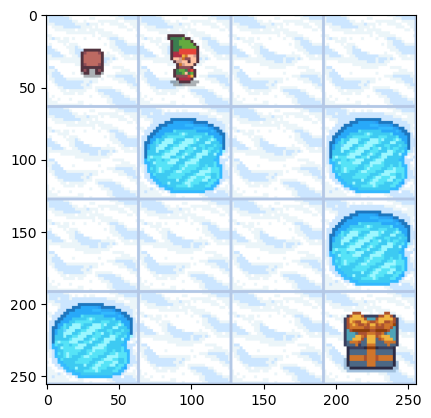

--------------------
obs: 1
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [1]; EPISODE [3]<=
position: 1
saved observation: you are in position 1. You moved from position 0. Your last action was to go right.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 1. You moved from position 0. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-7fddd433-bb4e-4f7d-b140-a2381d2ee671', 'object': 'text_completion', 'created': 1686082444, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 1. You moved from position 0. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe player should move 'right'.", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 155, 'completion_tokens': 8, 'total_tokens': 163}}
ge


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     6.39 ms /     9 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3485.16 ms /    59 tokens (   59.07 ms per token)
llama_print_timings:        eval time =   400.66 ms /     8 runs   (   50.08 ms per token)
llama_print_timings:       total time =  3988.20 ms


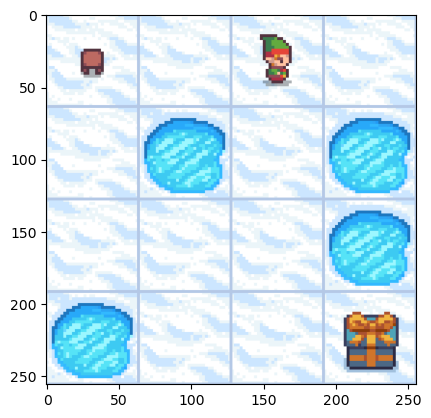

--------------------
obs: 2
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [2]; EPISODE [3]<=
position: 2
saved observation: you are in position 2. You moved from position 1. Your last action was to go right.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 2. You moved from position 1. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-0d599d2c-6ed2-48d2-8330-4f834f57a3e2', 'object': 'text_completion', 'created': 1686082448, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 2. You moved from position 1. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe player should move forward (right).", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 155, 'completion_tokens': 9, 'total_tokens': 


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     7.09 ms /    10 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3487.48 ms /    59 tokens (   59.11 ms per token)
llama_print_timings:        eval time =   460.58 ms /     9 runs   (   51.18 ms per token)
llama_print_timings:       total time =  4056.58 ms


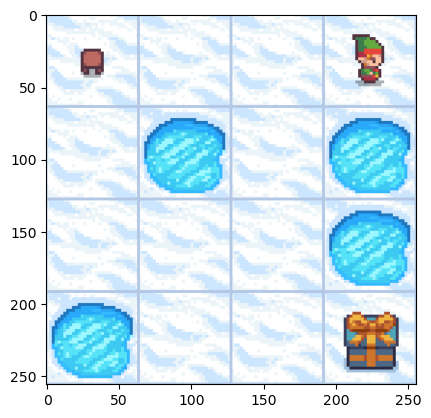

--------------------
obs: 3
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [3]; EPISODE [3]<=
position: 3
saved observation: you are in position 3. You moved from position 2. Your last action was to go right.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 3. You moved from position 2. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-112376ba-99a5-4398-a087-88cb9e28e4f6', 'object': 'text_completion', 'created': 1686082452, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 3. You moved from position 2. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe player should move to the right.", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 155, 'completion_tokens': 9, 'total_tokens': 164


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     7.12 ms /    10 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3476.91 ms /    59 tokens (   58.93 ms per token)
llama_print_timings:        eval time =   457.52 ms /     9 runs   (   50.84 ms per token)
llama_print_timings:       total time =  4042.68 ms


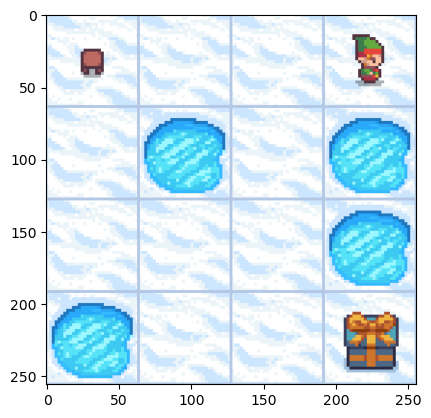

--------------------
obs: 3
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [4]; EPISODE [3]<=
position: 3
saved observation: you are still in position 3. You did not move. Your last action was to go right.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are still in position 3. You did not move. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-0701981d-fc56-4986-9fad-7a30c7051803', 'object': 'text_completion', 'created': 1686082456, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are still in position 3. You did not move. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe AI language model can predict the next direction based on the player's current position and previous action. Based on this information, the predicted direction is 'right'


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =    25.53 ms /    36 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3311.49 ms /    61 tokens (   54.29 ms per token)
llama_print_timings:        eval time =  1782.22 ms /    35 runs   (   50.92 ms per token)
llama_print_timings:       total time =  5312.54 ms


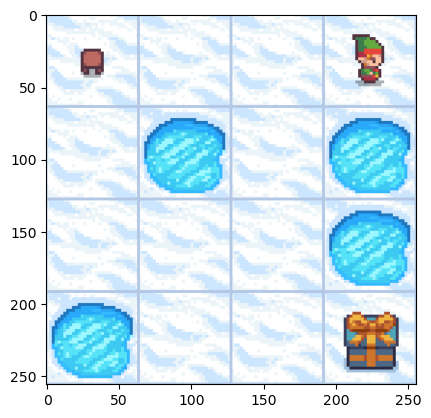

--------------------
obs: 3
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [5]; EPISODE [3]<=
position: 3
saved observation: you are still in position 3. You did not move. Your last action was to go right.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are still in position 3. You did not move. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-21395290-de81-48cc-990d-b9024ccc7fb0', 'object': 'text_completion', 'created': 1686082462, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are still in position 3. You did not move. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe player's current position is (3,3).", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 154, 'completion_tokens': 13, 'total_tokens': 16


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =    10.00 ms /    14 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =     0.00 ms /     1 tokens (    0.00 ms per token)
llama_print_timings:        eval time =   710.59 ms /    14 runs   (   50.76 ms per token)
llama_print_timings:       total time =   771.12 ms


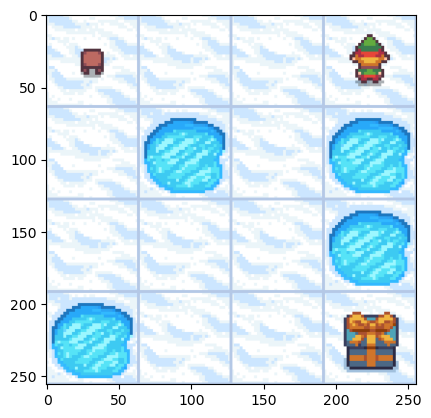

--------------------
obs: 3
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [6]; EPISODE [3]<=
position: 3
saved observation: you are still in position 3. You did not move. Your last action was to go up.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are still in position 3. You did not move. Your last action was to go up.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-d5e4eb50-a7b1-42c4-af34-27134e1a567c', 'object': 'text_completion', 'created': 1686082462, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are still in position 3. You did not move. Your last action was to go up.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe player should move to the right.", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 154, 'completion_tokens': 9, 'total_tokens': 163}}
gen


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     7.09 ms /    10 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3447.96 ms /    44 tokens (   78.36 ms per token)
llama_print_timings:        eval time =   450.63 ms /     9 runs   (   50.07 ms per token)
llama_print_timings:       total time =  3987.68 ms


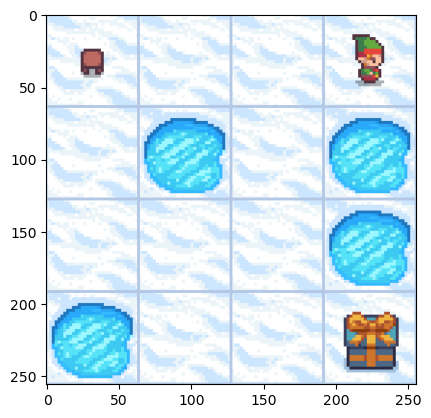

--------------------
obs: 3
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [7]; EPISODE [3]<=
position: 3
saved observation: you are still in position 3. You did not move. Your last action was to go right.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are still in position 3. You did not move. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-4a8f54d0-1b3a-422c-b654-423d9a6a4877', 'object': 'text_completion', 'created': 1686082466, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are still in position 3. You did not move. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe player should move 'right'.", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 154, 'completion_tokens': 8, 'total_tokens': 162}}
gener


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     6.46 ms /     9 runs   (    0.72 ms per token)
llama_print_timings: prompt eval time =  3402.88 ms /    44 tokens (   77.34 ms per token)
llama_print_timings:        eval time =   408.39 ms /     8 runs   (   51.05 ms per token)
llama_print_timings:       total time =  3896.97 ms


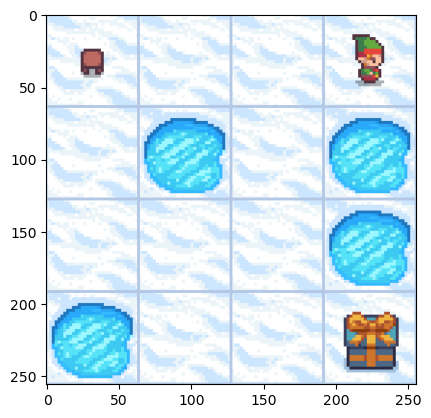

--------------------
obs: 3
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [8]; EPISODE [3]<=
position: 3
saved observation: you are still in position 3. You did not move. Your last action was to go right.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are still in position 3. You did not move. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-bb890ed6-bd97-413f-b7f0-040acc87fa44', 'object': 'text_completion', 'created': 1686082470, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are still in position 3. You did not move. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \n\nThe player should move 'down'.", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 154, 'completion_tokens': 9, 'total_tokens': 163}}
gene


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     7.14 ms /    10 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =     0.00 ms /     1 tokens (    0.00 ms per token)
llama_print_timings:        eval time =   549.62 ms /    10 runs   (   54.96 ms per token)
llama_print_timings:       total time =   590.05 ms


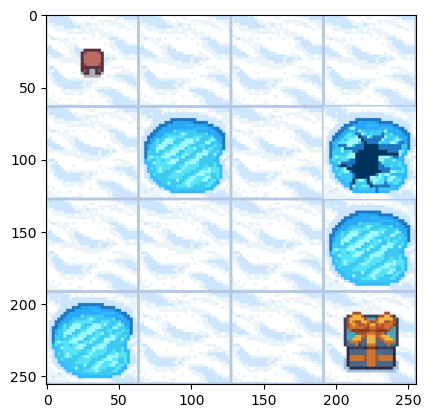

--------------------
obs: 7
reward: 0.0
terminated: True
truncated: False
info: {'prob': 1.0}
--------------------
Episode finished after 9 timesteps
observation: (0, {'prob': 1})
episode_reward: 0
=> TIMESTAMP [0]; EPISODE [4]<=
position: 0
saved observation: you are in position 0. You moved from position 3. Your last action was to go down.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 0. You moved from position 3. Your last action was to go down.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning h

Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-b8b3cac8-f034-4407-aca9-d935c8156a99', 'object': 'text_completion', 'created': 1686082471, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 0. You moved from position 3. Your last action was to go down.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \n\nAs an AI assistant, I do not have access to information about the game you are referring to. Therefore, I cannot accurately determine the correct direction for the player


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =    44.30 ms /    62 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3490.96 ms /    62 tokens (   56.31 ms per token)
llama_print_timings:        eval time =  3203.98 ms /    61 runs   (   52.52 ms per token)
llama_print_timings:       total time =  7045.72 ms


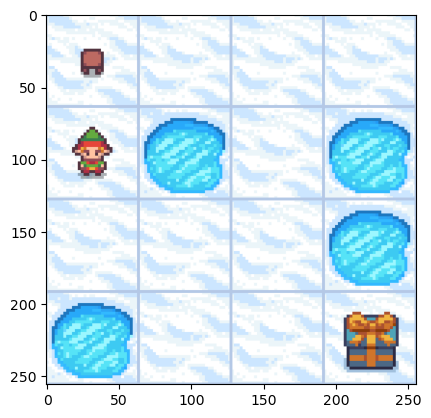

--------------------
obs: 4
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [1]; EPISODE [4]<=
position: 4
saved observation: you are in position 4. You moved from position 0. Your last action was to go down.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 4. You moved from position 0. Your last action was to go down.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-9e97e9de-af09-4c65-b2bb-bbd1f94c3183', 'object': 'text_completion', 'created': 1686082478, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 4. You moved from position 0. Your last action was to go down.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe player should move right.", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 155, 'completion_tokens': 7, 'total_tokens': 162}}
gener


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     5.64 ms /     8 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3498.16 ms /    59 tokens (   59.29 ms per token)
llama_print_timings:        eval time =   361.60 ms /     7 runs   (   51.66 ms per token)
llama_print_timings:       total time =  3967.04 ms


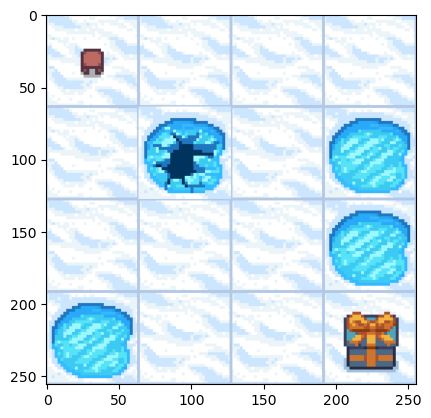

--------------------
obs: 5
reward: 0.0
terminated: True
truncated: False
info: {'prob': 1.0}
--------------------
Episode finished after 2 timesteps
observation: (0, {'prob': 1})
episode_reward: 0
=> TIMESTAMP [0]; EPISODE [5]<=
position: 0
saved observation: you are in position 0. You moved from position 4. Your last action was to go right.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 0. You moved from position 4. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning

Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-be8b91fe-2f96-42b9-9486-4dbb769b1950', 'object': 'text_completion', 'created': 1686082482, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 0. You moved from position 4. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe player should move to the right.", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 155, 'completion_tokens': 9, 'total_tokens': 164


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     7.10 ms /    10 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3472.21 ms /    59 tokens (   58.85 ms per token)
llama_print_timings:        eval time =   452.41 ms /     9 runs   (   50.27 ms per token)
llama_print_timings:       total time =  4030.49 ms


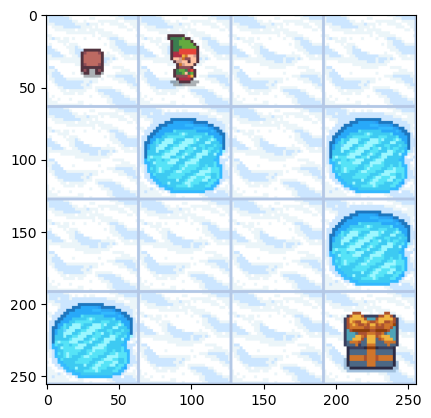

--------------------
obs: 1
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [1]; EPISODE [5]<=
position: 1
saved observation: you are in position 1. You moved from position 0. Your last action was to go right.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 1. You moved from position 0. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-47d1d626-6f58-482d-8202-2359896a04bf', 'object': 'text_completion', 'created': 1686082486, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 1. You moved from position 0. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe AI language model can not see the game or its controls and will need additional information to make an informed decision. Please provide more context about the game an


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =    33.43 ms /    47 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3472.66 ms /    59 tokens (   58.86 ms per token)
llama_print_timings:        eval time =  2325.41 ms /    46 runs   (   50.55 ms per token)
llama_print_timings:       total time =  6064.00 ms


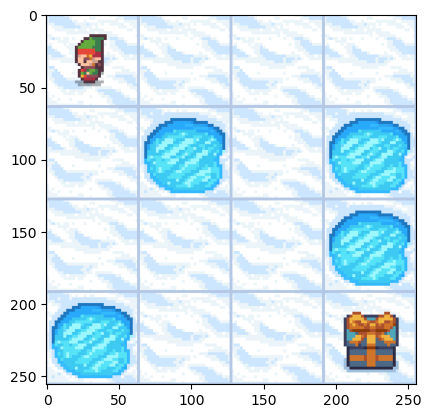

--------------------
obs: 0
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [2]; EPISODE [5]<=
position: 0
saved observation: you are in position 0. You moved from position 1. Your last action was to go left.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 0. You moved from position 1. Your last action was to go left.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-81fb1437-59b4-4511-a16c-9d57abf73444', 'object': 'text_completion', 'created': 1686082492, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 0. You moved from position 1. Your last action was to go left.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \n\nAs an AI assistant, I do not have access to your current position or previous actions in the game. Therefore, I cannot accurately determine the best direction for the pla


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =    52.11 ms /    73 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3472.83 ms /    59 tokens (   58.86 ms per token)
llama_print_timings:        eval time =  3912.20 ms /    72 runs   (   54.34 ms per token)
llama_print_timings:       total time =  7810.59 ms


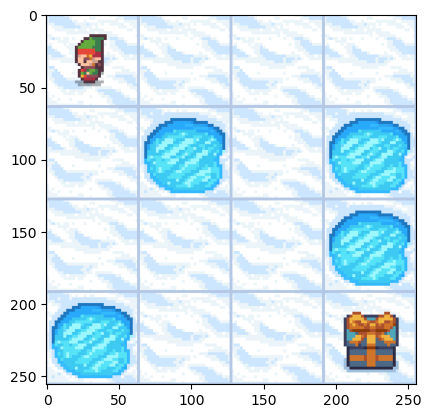

--------------------
obs: 0
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [3]; EPISODE [5]<=
position: 0
saved observation: you are still in position 0. You did not move. Your last action was to go left.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are still in position 0. You did not move. Your last action was to go left.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-816d9066-1f43-47f6-a1e2-35844eda90b0', 'object': 'text_completion', 'created': 1686082500, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are still in position 0. You did not move. Your last action was to go left.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe player can move either right or down.", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 154, 'completion_tokens': 10, 'total_tokens': 1


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     7.97 ms /    11 runs   (    0.72 ms per token)
llama_print_timings: prompt eval time =  3463.22 ms /    61 tokens (   56.77 ms per token)
llama_print_timings:        eval time =   539.59 ms /    10 runs   (   53.96 ms per token)
llama_print_timings:       total time =  4132.86 ms


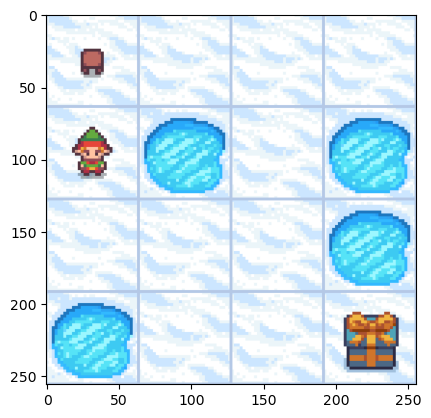

Llama.generate: prefix-match hit


--------------------
obs: 4
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [4]; EPISODE [5]<=
position: 4
saved observation: you are in position 4. You moved from position 0. Your last action was to go down.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 4. You moved from position 0. Your last action was to go down.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 
generated output: {'id': 'cmpl-956d000f-cd50-4637-87b2-62a9439c13fc',


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     5.64 ms /     8 runs   (    0.70 ms per token)
llama_print_timings: prompt eval time =  3373.47 ms /    62 tokens (   54.41 ms per token)
llama_print_timings:        eval time =   347.99 ms /     7 runs   (   49.71 ms per token)
llama_print_timings:       total time =  3826.02 ms


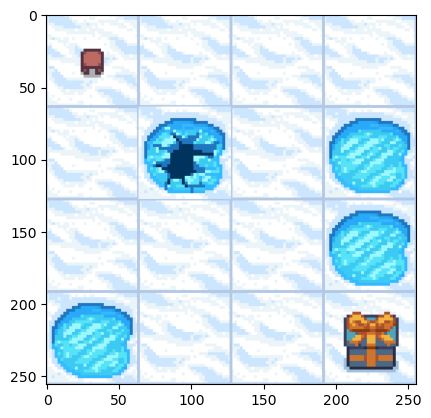

--------------------
obs: 5
reward: 0.0
terminated: True
truncated: False
info: {'prob': 1.0}
--------------------
Episode finished after 5 timesteps
observation: (0, {'prob': 1})
episode_reward: 0
=> TIMESTAMP [0]; EPISODE [6]<=
position: 0
saved observation: you are in position 0. You moved from position 4. Your last action was to go right.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 0. You moved from position 4. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning

Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-c14619f8-56d1-4fbc-b4fd-50cdfaf8443f', 'object': 'text_completion', 'created': 1686082508, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 0. You moved from position 4. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe correct answer is 'right'.", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 155, 'completion_tokens': 8, 'total_tokens': 163}}
gen


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     6.41 ms /     9 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3490.25 ms /    59 tokens (   59.16 ms per token)
llama_print_timings:        eval time =   413.13 ms /     8 runs   (   51.64 ms per token)
llama_print_timings:       total time =  4006.59 ms


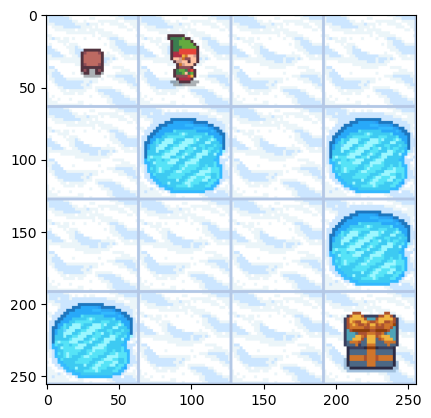

--------------------
obs: 1
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [1]; EPISODE [6]<=
position: 1
saved observation: you are in position 1. You moved from position 0. Your last action was to go right.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 1. You moved from position 0. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-107f7efc-bd0b-42ec-a933-5e3f1d031499', 'object': 'text_completion', 'created': 1686082512, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': 'We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: \'left\', \'down\', \'right\', \'up\'. This is your last observation about positioning in the game you are in position 1. You moved from position 0. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \n\nAs an AI assistant, I do not have knowledge about the specific game you are referring to. However, based on the information provided, it seems that the player is


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =    44.69 ms /    63 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3477.98 ms /    59 tokens (   58.95 ms per token)
llama_print_timings:        eval time =  3099.83 ms /    62 runs   (   50.00 ms per token)
llama_print_timings:       total time =  6927.77 ms


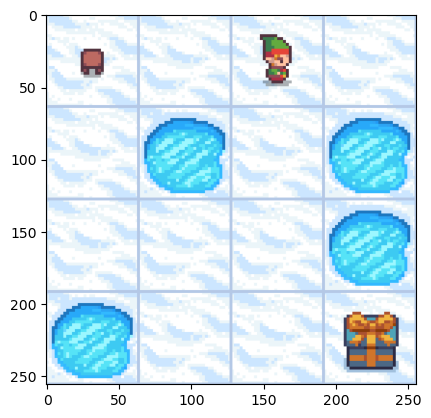

--------------------
obs: 2
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [2]; EPISODE [6]<=
position: 2
saved observation: you are in position 2. You moved from position 1. Your last action was to go right.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 2. You moved from position 1. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-16167fd2-0601-4943-aaa1-72f83514e121', 'object': 'text_completion', 'created': 1686082519, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 2. You moved from position 1. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe player should move right.", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 155, 'completion_tokens': 7, 'total_tokens': 162}}
gene


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     5.69 ms /     8 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3489.94 ms /    59 tokens (   59.15 ms per token)
llama_print_timings:        eval time =   349.34 ms /     7 runs   (   49.91 ms per token)
llama_print_timings:       total time =  3945.65 ms


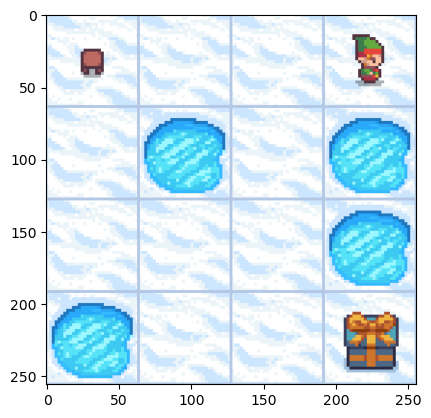

--------------------
obs: 3
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [3]; EPISODE [6]<=
position: 3
saved observation: you are in position 3. You moved from position 2. Your last action was to go right.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 3. You moved from position 2. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-fe7d18b8-e997-43f7-b8fb-1de1762cb184', 'object': 'text_completion', 'created': 1686082523, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 3. You moved from position 2. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe player should move left.", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 155, 'completion_tokens': 7, 'total_tokens': 162}}
gener


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     5.71 ms /     8 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3503.14 ms /    59 tokens (   59.38 ms per token)
llama_print_timings:        eval time =   348.27 ms /     7 runs   (   49.75 ms per token)
llama_print_timings:       total time =  3949.10 ms


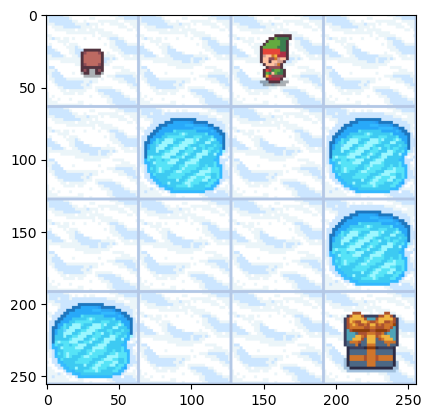

--------------------
obs: 2
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [4]; EPISODE [6]<=
position: 2
saved observation: you are in position 2. You moved from position 3. Your last action was to go left.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 2. You moved from position 3. Your last action was to go left.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-905c76c8-eecf-48b3-9b85-83817027ed5e', 'object': 'text_completion', 'created': 1686082527, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 2. You moved from position 3. Your last action was to go left.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe player should move 'down'.", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 155, 'completion_tokens': 8, 'total_tokens': 163}}
gene


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     6.38 ms /     9 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3481.86 ms /    59 tokens (   59.01 ms per token)
llama_print_timings:        eval time =   400.51 ms /     8 runs   (   50.06 ms per token)
llama_print_timings:       total time =  3985.38 ms


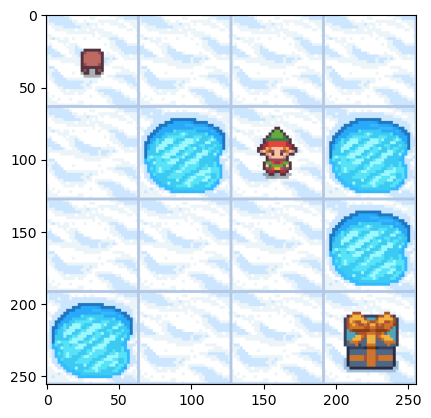

--------------------
obs: 6
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [5]; EPISODE [6]<=
position: 6
saved observation: you are in position 6. You moved from position 2. Your last action was to go down.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 6. You moved from position 2. Your last action was to go down.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-e9441e4c-0c37-4194-b52e-f9e23cfec2aa', 'object': 'text_completion', 'created': 1686082532, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 6. You moved from position 2. Your last action was to go down.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nTo clarify: The player is currently in position 6 on the map and wants to reach position 7 which is in the bottom right corner of the map. They can move in the four directi


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =    52.17 ms /    73 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3682.49 ms /    59 tokens (   62.42 ms per token)
llama_print_timings:        eval time =  3799.70 ms /    72 runs   (   52.77 ms per token)
llama_print_timings:       total time =  7881.83 ms


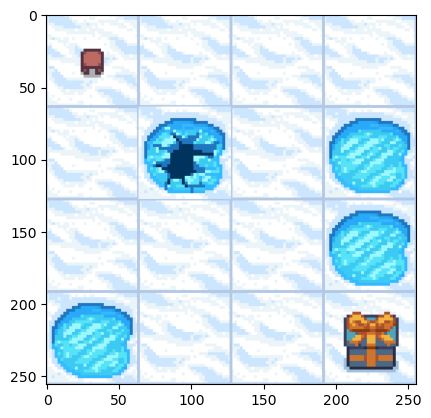

--------------------
obs: 5
reward: 0.0
terminated: True
truncated: False
info: {'prob': 1.0}
--------------------
Episode finished after 6 timesteps
observation: (0, {'prob': 1})
episode_reward: 0
=> TIMESTAMP [0]; EPISODE [7]<=
position: 0
saved observation: you are in position 0. You moved from position 6. Your last action was to go left.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 0. You moved from position 6. Your last action was to go left.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning h

Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-be1f1dd8-c07a-406f-87dc-bbdf5bfb9f08', 'object': 'text_completion', 'created': 1686082539, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 0. You moved from position 6. Your last action was to go left.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe player should move 'down'.", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 155, 'completion_tokens': 8, 'total_tokens': 163}}
gene


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     6.42 ms /     9 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3494.35 ms /    59 tokens (   59.23 ms per token)
llama_print_timings:        eval time =   400.09 ms /     8 runs   (   50.01 ms per token)
llama_print_timings:       total time =  4006.34 ms


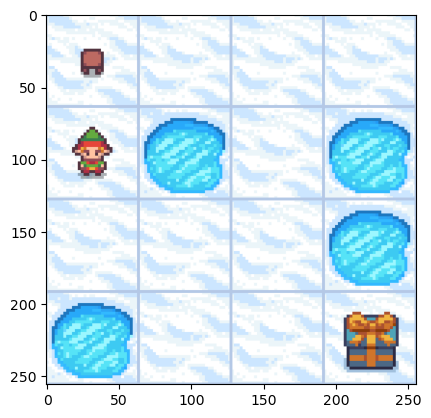

Llama.generate: prefix-match hit


--------------------
obs: 4
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [1]; EPISODE [7]<=
position: 4
saved observation: you are in position 4. You moved from position 0. Your last action was to go down.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 4. You moved from position 0. Your last action was to go down.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 
generated output: {'id': 'cmpl-e3b2e9f1-bb5d-46d5-800f-21b691f57e93',


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     6.42 ms /     9 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3467.38 ms /    59 tokens (   58.77 ms per token)
llama_print_timings:        eval time =   399.50 ms /     8 runs   (   49.94 ms per token)
llama_print_timings:       total time =  3969.38 ms


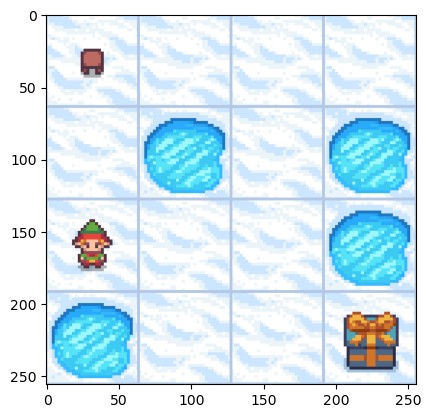

Llama.generate: prefix-match hit


--------------------
obs: 8
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [2]; EPISODE [7]<=
position: 8
saved observation: you are in position 8. You moved from position 4. Your last action was to go down.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 8. You moved from position 4. Your last action was to go down.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 
generated output: {'id': 'cmpl-9a1ead5d-5142-42d4-91aa-6f0cdb898738',


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     5.69 ms /     8 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3481.48 ms /    59 tokens (   59.01 ms per token)
llama_print_timings:        eval time =   354.18 ms /     7 runs   (   50.60 ms per token)
llama_print_timings:       total time =  3933.80 ms


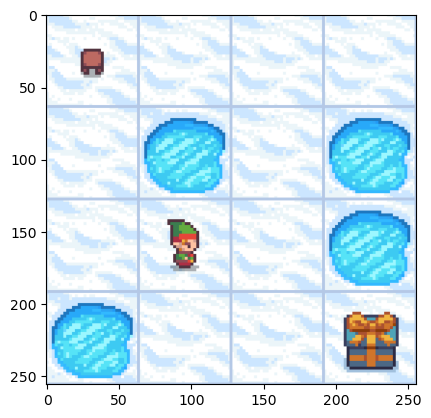

--------------------
obs: 9
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [3]; EPISODE [7]<=
position: 9
saved observation: you are in position 9. You moved from position 8. Your last action was to go right.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 9. You moved from position 8. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-7c2fec4c-0baa-4223-a0ec-a247383eef37', 'object': 'text_completion', 'created': 1686082552, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 9. You moved from position 8. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe player should move to the right.", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 155, 'completion_tokens': 9, 'total_tokens': 164


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     7.09 ms /    10 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3548.79 ms /    59 tokens (   60.15 ms per token)
llama_print_timings:        eval time =   647.32 ms /     9 runs   (   71.92 ms per token)
llama_print_timings:       total time =  4305.48 ms


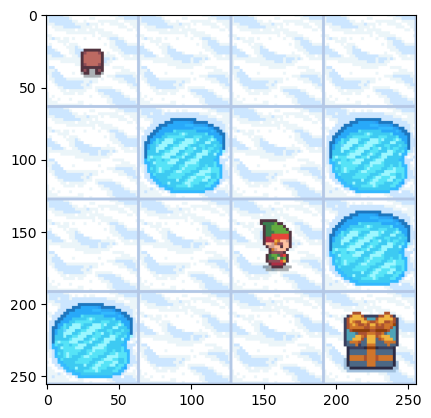

--------------------
obs: 10
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [4]; EPISODE [7]<=
position: 10
saved observation: you are in position 10. You moved from position 9. Your last action was to go right.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 10. You moved from position 9. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-4e6b58a7-10c4-45bd-845e-28abff604ec6', 'object': 'text_completion', 'created': 1686082556, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 10. You moved from position 9. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nPlease note that there may be multiple possible solutions to reach the destination depending on the current state of the game and the obstacles encountered along the way.


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =    22.93 ms /    32 runs   (    0.72 ms per token)
llama_print_timings: prompt eval time =  3506.30 ms /    60 tokens (   58.44 ms per token)
llama_print_timings:        eval time =  1795.04 ms /    31 runs   (   57.90 ms per token)
llama_print_timings:       total time =  5513.27 ms


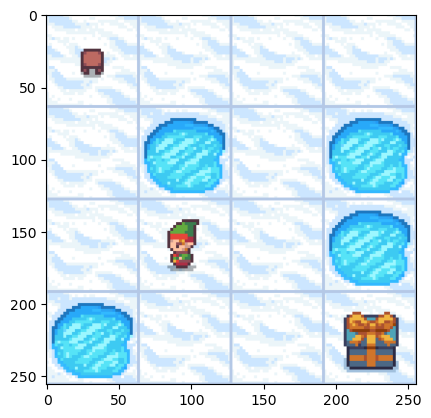

--------------------
obs: 9
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [5]; EPISODE [7]<=
position: 9
saved observation: you are in position 9. You moved from position 10. Your last action was to go left.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 9. You moved from position 10. Your last action was to go left.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-e9a727bc-dd3b-460e-969c-9ce94da74a57', 'object': 'text_completion', 'created': 1686082562, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 9. You moved from position 10. Your last action was to go left.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe player should move right.", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 156, 'completion_tokens': 7, 'total_tokens': 163}}
gene


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     5.71 ms /     8 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3494.90 ms /    60 tokens (   58.25 ms per token)
llama_print_timings:        eval time =   365.54 ms /     7 runs   (   52.22 ms per token)
llama_print_timings:       total time =  3965.97 ms


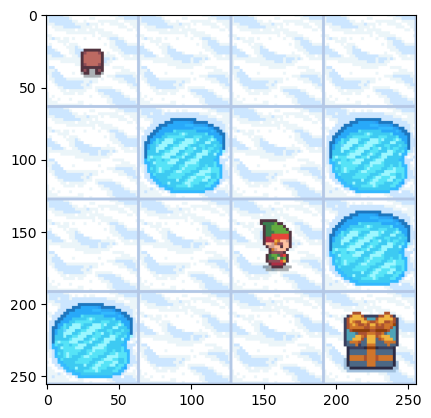

--------------------
obs: 10
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [6]; EPISODE [7]<=
position: 10
saved observation: you are in position 10. You moved from position 9. Your last action was to go right.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 10. You moved from position 9. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-7bb391c8-2f7f-4814-8e0e-96b90b5e29a8', 'object': 'text_completion', 'created': 1686082566, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 10. You moved from position 9. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe player should move forward (right).", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 156, 'completion_tokens': 9, 'total_tokens':


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     7.10 ms /    10 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3560.71 ms /    60 tokens (   59.35 ms per token)
llama_print_timings:        eval time =   496.12 ms /     9 runs   (   55.12 ms per token)
llama_print_timings:       total time =  4168.95 ms


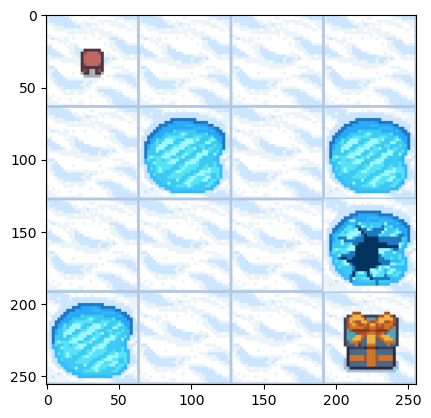

--------------------
obs: 11
reward: 0.0
terminated: True
truncated: False
info: {'prob': 1.0}
--------------------
Episode finished after 7 timesteps
observation: (0, {'prob': 1})
episode_reward: 0
=> TIMESTAMP [0]; EPISODE [8]<=
position: 0
saved observation: you are in position 0. You moved from position 10. Your last action was to go right.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 0. You moved from position 10. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learn

Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-951760a1-3401-43a5-b0dd-7546ace2b778', 'object': 'text_completion', 'created': 1686082570, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 0. You moved from position 10. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe player should move to the left.", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 156, 'completion_tokens': 9, 'total_tokens': 165


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     7.13 ms /    10 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3589.84 ms /    60 tokens (   59.83 ms per token)
llama_print_timings:        eval time =   533.78 ms /     9 runs   (   59.31 ms per token)
llama_print_timings:       total time =  4237.58 ms


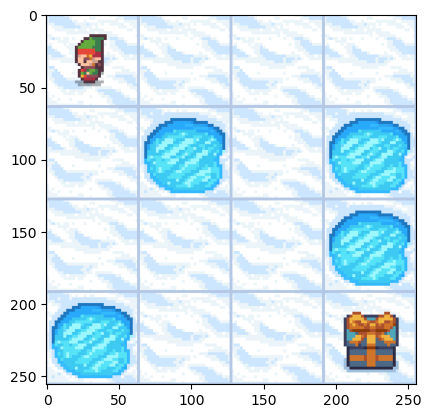

--------------------
obs: 0
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [1]; EPISODE [8]<=
position: 0
saved observation: you are still in position 0. You did not move. Your last action was to go left.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are still in position 0. You did not move. Your last action was to go left.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-b72764f4-5b8f-4446-813a-6efee118edf2', 'object': 'text_completion', 'created': 1686082574, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are still in position 0. You did not move. Your last action was to go left.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \n\nAs an AI assistant, I am not able to observe or make decisions on behalf of a game player. However, based on the information provided, it seems that the player is currently 


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =    50.69 ms /    71 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3356.61 ms /    61 tokens (   55.03 ms per token)
llama_print_timings:        eval time =  3716.04 ms /    70 runs   (   53.09 ms per token)
llama_print_timings:       total time =  7479.73 ms


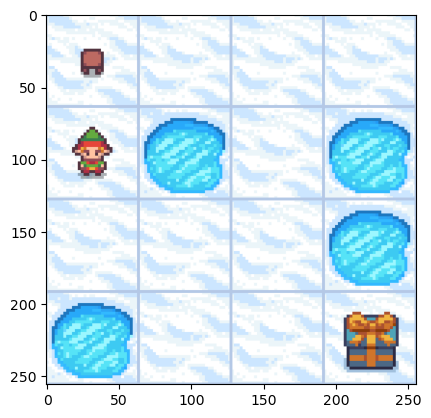

--------------------
obs: 4
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [2]; EPISODE [8]<=
position: 4
saved observation: you are in position 4. You moved from position 0. Your last action was to go down.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 4. You moved from position 0. Your last action was to go down.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-d74148cb-8924-4d8c-84a2-c19c175445fb', 'object': 'text_completion', 'created': 1686082582, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 4. You moved from position 0. Your last action was to go down.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe player should move right.", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 155, 'completion_tokens': 7, 'total_tokens': 162}}
gener


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     5.69 ms /     8 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3382.21 ms /    62 tokens (   54.55 ms per token)
llama_print_timings:        eval time =   376.08 ms /     7 runs   (   53.73 ms per token)
llama_print_timings:       total time =  3873.01 ms


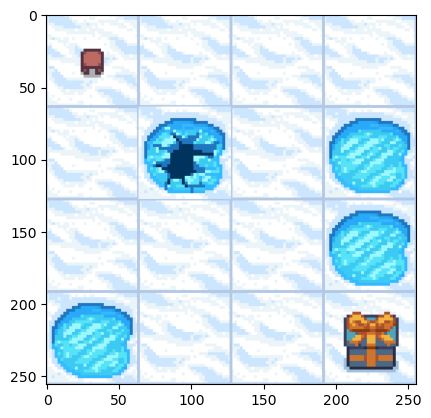

--------------------
obs: 5
reward: 0.0
terminated: True
truncated: False
info: {'prob': 1.0}
--------------------
Episode finished after 3 timesteps
observation: (0, {'prob': 1})
episode_reward: 0
=> TIMESTAMP [0]; EPISODE [9]<=
position: 0
saved observation: you are in position 0. You moved from position 4. Your last action was to go right.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 0. You moved from position 4. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning

Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-3715ea38-43f8-4949-8d78-2e4f3a560e6f', 'object': 'text_completion', 'created': 1686082586, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 0. You moved from position 4. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe player should move to the right.", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 155, 'completion_tokens': 9, 'total_tokens': 164


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     7.19 ms /    10 runs   (    0.72 ms per token)
llama_print_timings: prompt eval time =  3525.15 ms /    59 tokens (   59.75 ms per token)
llama_print_timings:        eval time =   478.42 ms /     9 runs   (   53.16 ms per token)
llama_print_timings:       total time =  4114.66 ms


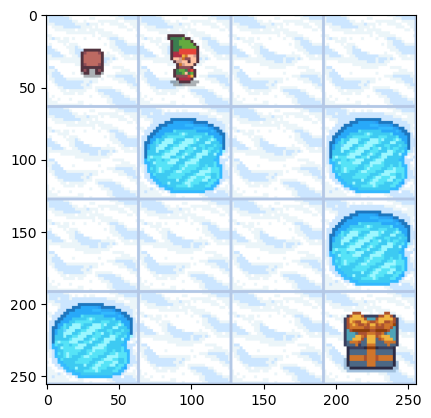

--------------------
obs: 1
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [1]; EPISODE [9]<=
position: 1
saved observation: you are in position 1. You moved from position 0. Your last action was to go right.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 1. You moved from position 0. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-c4c6884e-52f5-419c-9c12-6b1c94b94fd4', 'object': 'text_completion', 'created': 1686082590, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 1. You moved from position 0. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe player should move to the right.", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 155, 'completion_tokens': 9, 'total_tokens': 164


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     7.21 ms /    10 runs   (    0.72 ms per token)
llama_print_timings: prompt eval time =  3663.66 ms /    59 tokens (   62.10 ms per token)
llama_print_timings:        eval time =   527.06 ms /     9 runs   (   58.56 ms per token)
llama_print_timings:       total time =  4315.06 ms


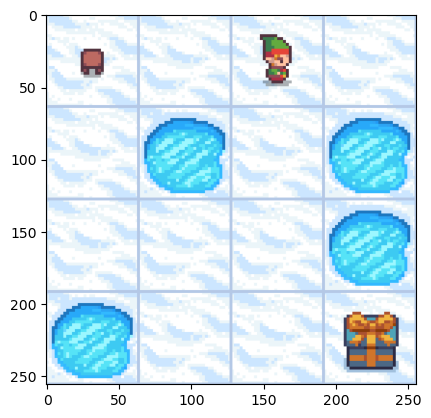

--------------------
obs: 2
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [2]; EPISODE [9]<=
position: 2
saved observation: you are in position 2. You moved from position 1. Your last action was to go right.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 2. You moved from position 1. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-95d6d987-8c3c-47de-9ce3-630403fcb2a8', 'object': 'text_completion', 'created': 1686082594, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 2. You moved from position 1. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe player should move forward (right).", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 155, 'completion_tokens': 9, 'total_tokens': 


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =     7.16 ms /    10 runs   (    0.72 ms per token)
llama_print_timings: prompt eval time =  3523.42 ms /    59 tokens (   59.72 ms per token)
llama_print_timings:        eval time =   478.76 ms /     9 runs   (   53.20 ms per token)
llama_print_timings:       total time =  4111.34 ms


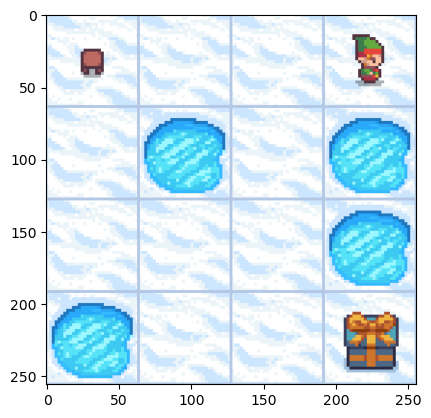

--------------------
obs: 3
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [3]; EPISODE [9]<=
position: 3
saved observation: you are in position 3. You moved from position 2. Your last action was to go right.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 3. You moved from position 2. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-31f9d007-ccb3-49ec-a45e-94625421c552', 'object': 'text_completion', 'created': 1686082598, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 3. You moved from position 2. Your last action was to go right.. What direction should the player move? (please provide only the direction name, one word) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe AI language model cannot see or interact with the game in any way, so it is not capable of playing the game at this time. However, based on the information provided, i


llama_print_timings:        load time =  9136.85 ms
llama_print_timings:      sample time =    44.35 ms /    62 runs   (    0.72 ms per token)
llama_print_timings: prompt eval time =  3531.56 ms /    59 tokens (   59.86 ms per token)
llama_print_timings:        eval time =  3248.13 ms /    61 runs   (   53.25 ms per token)
llama_print_timings:       total time =  7138.46 ms


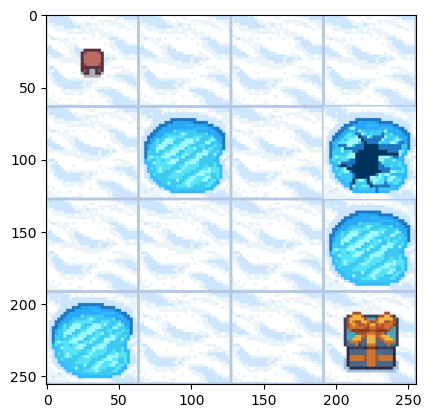

--------------------
obs: 7
reward: 0.0
terminated: True
truncated: False
info: {'prob': 1.0}
--------------------
Episode finished after 4 timesteps


In [9]:

rewards = []
observations = []
actions_taken = []
position_old = None

for i_episode in range(10):
    observation = env.reset()
    print(f"observation: {observation}")
    observations.append(observation)

    episode_reward = 0
    print(f"episode_reward: {episode_reward}")

    # Loop over t timesteps 
    for t in range(20):

        print(f"=> TIMESTAMP [{t}]; EPISODE [{i_episode}]<=")

        # Set position ot the last index in observations
        position = observations[-1][0]
        print(f"position: {position}")

        # Give the LLM some information about the current state of the game

        if (position_old is not None) and (position_old != position):
            # save observation
            agent.save_observation(f"you are in position {position}. You moved from position {position_old}. Your last action was to go {actions_taken[-1]}.")
        elif position_old is None:
        
            agent.save_observation(f"you are in position {position}. This is the start of the game.")
        else:
            # save observation
            agent.save_observation(f"you are still in position {position}. You did not move. Your last action was to go {actions_taken[-1]}.")
        
        
        
        # print(f"saved observation: you are in position {position}")

        # generate action
        action = agent.generate_action(debug=True)
        print("selected action", action)

        # take action
        # Within the game board state
        obs, reward, terminated, truncated, info = env.step(action)

        print("GENERATED ACTION: ", action_space[action])
        print("##################################################")
        # print("RENEDERED ACTION: ", env.render())
        #show the image of the render of the action
        plt.imshow(env.render())
        plt.show()


        print("--------------------")
        print(f"obs: {obs}")
        print(f"reward: {reward}")
        print(f"terminated: {terminated}")
        print(f"truncated: {truncated}")
        print(f"info: {info}")
        print("--------------------")

        observations.append((obs, info))

        # save reward
        agent.save_reward(reward)

        position_old = position

        actions_taken.append(action_space[action])

        # If the episode terminated prematurely, save the reward and stop the episode
        if terminated:
            print("Episode finished after {} timesteps".format(t+1))
            rewards.append(reward)
            break

        if t == 9:
            rewards.append(reward)



[0.0, 0.0]


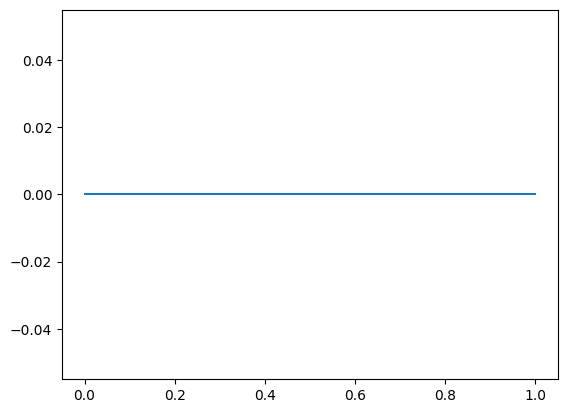

In [9]:
print(rewards)
plt.plot(rewards)